<a href="https://colab.research.google.com/github/kanishkjain1995/Face-Recognition/blob/master/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from google.colab import files, drive
import os, cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir lfw_mtcnnpy_160

In [0]:
!tar -xf gdrive/My\ Drive/lfw_mtcnnpy_160.tgz lfw_mtcnnpy_160

In [0]:
dataset_path = "lfw_mtcnnpy_160"

In [6]:
dim = (64, 64)
faces = []
names = []
index = 0
for name in os.listdir(dataset_path):
    image_file_path = os.path.join(dataset_path, name)
    if os.path.isfile(image_file_path):
        continue
    if len(os.listdir(image_file_path)) <= 2:
        continue
    for image_file in os.listdir(image_file_path):
        image_path = os.path.join(image_file_path, image_file)
        if image_file[0]==".":
            break
        image = cv2.imread(image_path)
        image = cv2.resize(image, dim)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces.append(image)
        names.append(name)
    index+=1

faces = np.stack(faces)/255.0
names = np.stack(names)
print(faces.shape, names.shape)

(7597, 64, 64, 3) (7597,)


In [0]:
ind = np.random.choice(range(faces.shape[0]), 1)[0]

Colin_Powell


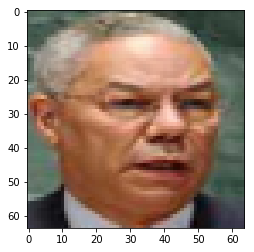

In [8]:
plt.imshow(faces[ind])
print(names[ind])

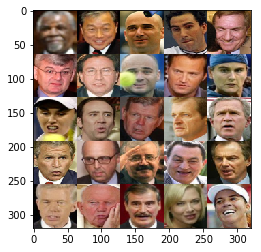

In [10]:
indexes = np.random.choice(range(len(faces)), 5)
img = np.vstack([np.hstack([faces[ind] for ind in np.random.choice(range(len(faces)), 5)]) for i in range(5)])
plt.imshow(img)
plt.show()

In [0]:
 def generate_data(x, y):       
        unique, count = np.unique(y, return_counts=True)
        ind = np.where(count > 1)[0]
        left_faces = []
        right_faces = []
        labels = []
        for name in unique[ind]:
            indx = np.where(y == name)[0]
            n_indx = np.where(y != name)[0]
            for i in range(len(indx)):
                index = np.random.choice(indx, 2, replace=False)
                left_faces.append(x[index][0])
                right_faces.append(x[index][1])
                labels.append(1)
            for i in range(len(indx)):
                n_index = [np.random.choice(n_indx, 1, replace=False)[0], np.random.choice(indx, 1, replace=False)[0]]
                left_faces.append(x[n_index][0])
                right_faces.append(x[n_index][1])
                labels.append(0)

        left_faces = np.stack(left_faces)
        right_faces = np.stack(right_faces)
        labels = np.stack(labels)
        return left_faces, right_faces, labels

In [0]:
left_faces, right_faces, labels = generate_data(faces, names)

In [0]:
def train_val_split(left_faces, right_faces, labels, val_split):
    data = {}
    data_len = len(labels)
    val_size = int(data_len*val_split)
    train_size = data_len - val_size
    
    indices = list(range(data_len))
    train_indices = np.random.choice(indices, train_size)
    val_indices = np.setdiff1d(indices, train_indices)
    
    train_data = (left_faces[train_indices], right_faces[train_indices], labels[train_indices])
    val_data = (left_faces[val_indices], right_faces[val_indices], labels[val_indices])

    data['train'] = train_data
    data['val'] = val_data

    return data

In [0]:
data = train_val_split(left_faces, right_faces, labels, val_split=0.1)

In [0]:
left_faces_train, right_faces_train, labels_train = data['train']
left_faces_test, right_faces_test, labels_test = data['val']

In [16]:
left_faces_train.shape, left_faces_test.shape

((13673, 64, 64, 3), (6213, 64, 64, 3))

In [0]:
def image_generator(left_faces, right_faces, labels, batch_size):
    generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True
    )
    generatorLeftImage = generator.flow(left_faces, labels, batch_size=batch_size, seed=1)
    generatorRightImage = generator.flow(right_faces, labels, batch_size=batch_size, seed=1)
    while True:
        leftImage = generatorLeftImage.next()
        rightImage = generatorRightImage.next()
        yield [leftImage[0], rightImage[0]], leftImage[1]

In [0]:
input_shape = (64, 64, 3)

In [19]:
embedding_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
embedding_model.summary()

W0803 06:16:12.905958 139696483293056 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [23]:
model = tf.keras.models.Sequential([
    embedding_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.LayerNormalization()
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
layer_normalization (LayerNo (None, 1024)              2048      
Total params: 22,124,608
Trainable params: 22,124,608
Non-trainable params: 0
_________________________________________________________________


In [0]:
left_input = tf.keras.Input(input_shape)
right_input = tf.keras.Input(input_shape)

encoded_l = model(left_input)
encoded_r = model(right_input)

l1_layer = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
similarity = l1_layer([encoded_l, encoded_r])
    
prediction = tf.keras.layers.Dense(1,activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-2))(similarity)

siamese_net = tf.keras.Model(inputs=[left_input,right_input], outputs=prediction)

In [25]:
optimizer = tf.train.AdamOptimizer(2e-6)
siamese_net.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

W0803 06:29:56.111165 139696483293056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
data_len = len(left_faces_train)
batch_size = 512

In [27]:
history = siamese_net.fit_generator(image_generator(left_faces_train, right_faces_train, labels_train, batch_size=batch_size), 
                          steps_per_epoch=data_len//batch_size, epochs=70, 
                          validation_data=([left_faces_test, right_faces_test], labels_test))

Epoch 1/40
26/26 [==============================] - 93s 4s/step - loss: 0.7289 - acc: 0.5210 - val_loss: 0.7233 - val_acc: 0.5300
Epoch 2/40
26/26 [==============================] - 80s 3s/step - loss: 0.7016 - acc: 0.5641 - val_loss: 0.7030 - val_acc: 0.5630
Epoch 3/40
26/26 [==============================] - 73s 3s/step - loss: 0.6824 - acc: 0.5868 - val_loss: 0.6897 - val_acc: 0.5870
Epoch 4/40
26/26 [==============================] - 73s 3s/step - loss: 0.6662 - acc: 0.6128 - val_loss: 0.6728 - val_acc: 0.6037
Epoch 5/40
26/26 [==============================] - 73s 3s/step - loss: 0.6512 - acc: 0.6262 - val_loss: 0.6606 - val_acc: 0.6224
Epoch 6/40
26/26 [==============================] - 73s 3s/step - loss: 0.6329 - acc: 0.6539 - val_loss: 0.6464 - val_acc: 0.6416
Epoch 7/40
26/26 [==============================] - 73s 3s/step - loss: 0.6232 - acc: 0.6678 - val_loss: 0.6348 - val_acc: 0.6589
Epoch 8/40
26/26 [==============================] - 73s 3s/step - loss: 0.6032 - acc: 0.68

Text(0.5, 1.0, 'acc')

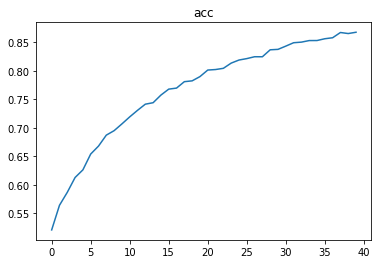

In [28]:
plt.plot(history.history['acc'])
plt.title("acc")

Text(0.5, 1.0, 'val_acc')

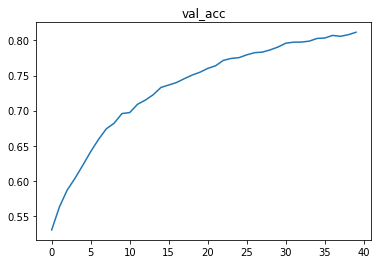

In [29]:
plt.plot(history.history['val_acc'])
plt.title("val_acc")

Text(0.5, 1.0, 'loss')

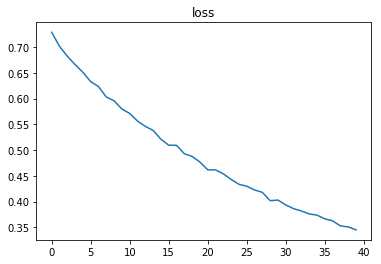

In [30]:
plt.plot(history.history['loss'])
plt.title("loss")

Text(0.5, 1.0, 'val_loss')

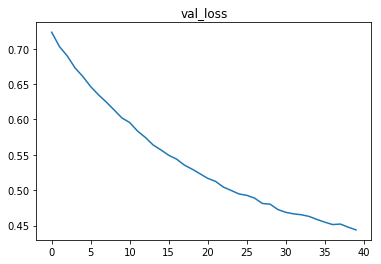

In [31]:
plt.plot(history.history['val_loss'])
plt.title("val_loss")